In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import gradient_descent
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

cuda
[0.4862745  0.38431373 0.3254902 ]


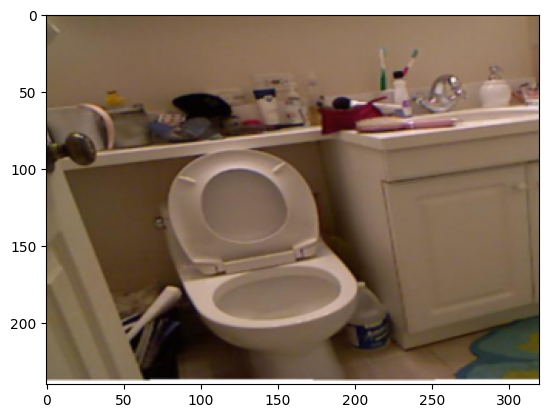

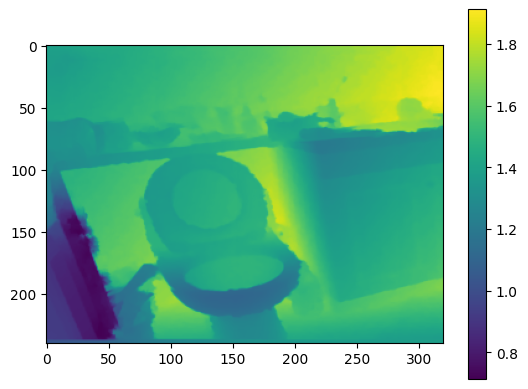

adaptive kernel size set to 11


In [2]:
globals.init_NYUv2()

# EXPERIMENT_NAME = 'coord-descent-bracket-search'
# experiment_folder = utils.create_experiment_folder(EXPERIMENT_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

IMAGE_RANGE = 255.

# load data 
# gt_aif, gt_dpt = utils.load_single_sample(sample='0101', set='train', fs=5, res='half')
gt_aif, gt_dpt, _ = utils.load_sample_image(fs=5, res='half')
gt_aif = gt_aif * IMAGE_RANGE

plt.imshow(gt_aif / IMAGE_RANGE)
plt.show()

plt.imshow(gt_dpt)
plt.colorbar()
plt.show()

width, height = gt_dpt.shape

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007330422..1.0363318].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009103271..1.007969].


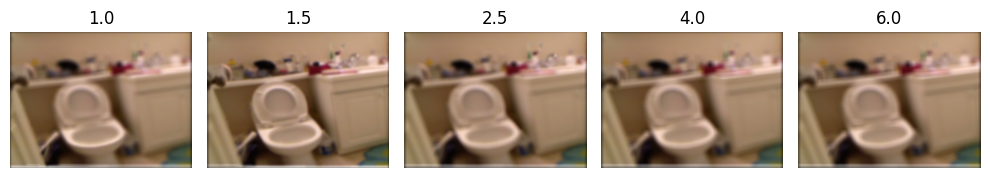

In [3]:
# forward model (torch)
FORWARD_KERNEL_TYPE = 'gaussian'
defocus_stack = forward_model.forward(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)
defocus_stack_torch = forward_model.forward_torch(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)#.float() / 255.0)
utils.plot_single_stack(defocus_stack_torch / IMAGE_RANGE, globals.Df)



In [4]:
k=3
depth_maps, Z, k_min_indices, all_losses = section_search.grid_search_opt_k(gt_aif, defocus_stack_torch)

# k=1
# depth_maps, Z, k_min_indices, all_losses = section_search.grid_search_opt(gt_aif, defocus_stack_torch)
# k_min_indices = np.expand_dims(k_min_indices, axis=-1)


Grid search         : 100%|███████████████████| 100/100 [00:33<00:00,  2.96it/s]

(240, 320, 3)
(240, 320, 3) (240, 320, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1..4.6].


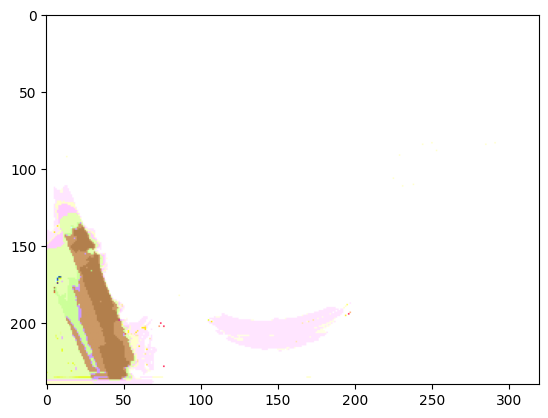

In [5]:
plt.imshow(depth_maps, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.show()

Golden-section search...
...searching for 100 % convergence
...done


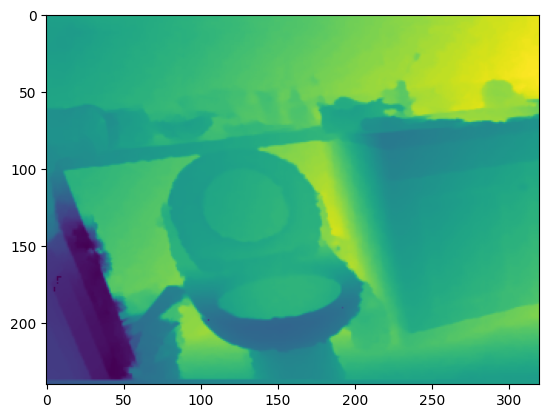

Golden-section search...
...searching for 100 % convergence
...done


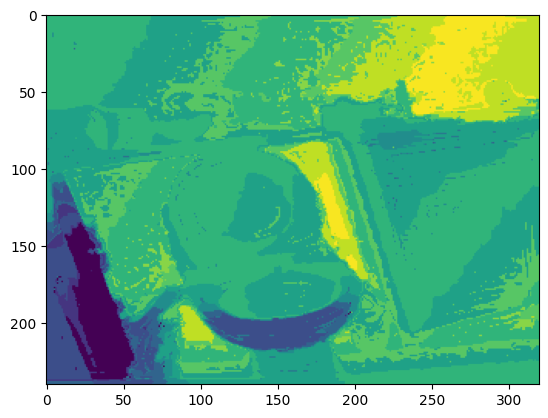

Golden-section search...
...searching for 100 % convergence
...done


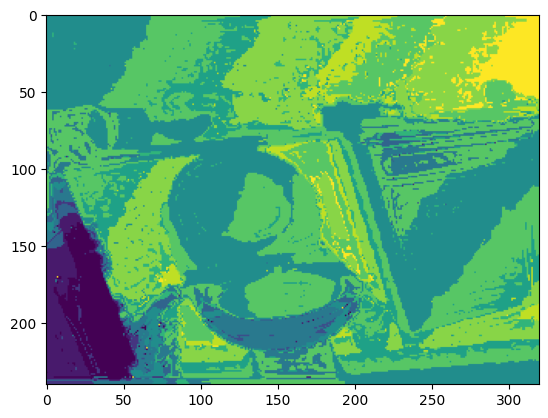

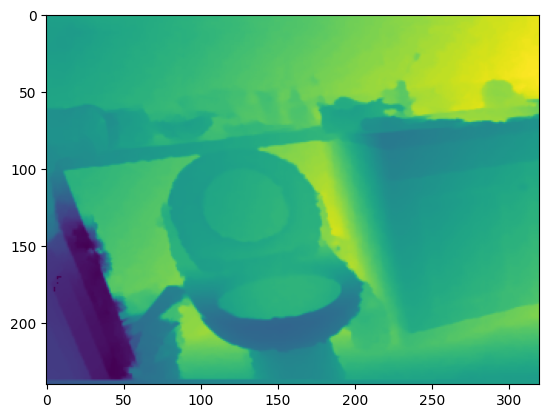

In [6]:
last_depth_map_golden = None
for kk in range(k):
    depth_map_golden = section_search.golden_section_search(Z, k_min_indices[:,:,kk], gt_aif, defocus_stack_torch,
                                                            window=1, tolerance=1e-6)
    plt.imshow(depth_map_golden, vmin = gt_dpt.min(), vmax = gt_dpt.max())
    plt.show()
    # chose which is better 
    if last_depth_map_golden is None:
        last_depth_map_golden = depth_map_golden
    else:
        mse = section_search.objective_full(depth_map_golden, gt_aif, defocus_stack_torch, gamma=0, similarity_penalty=False, last_dpt=None)
        last_mse = section_search.objective_full(last_depth_map_golden, gt_aif, defocus_stack_torch, gamma=0, similarity_penalty=False, last_dpt=None)
        last_depth_map_golden = np.where(mse <= last_mse, depth_map_golden, last_depth_map_golden)
        
        
if last_depth_map_golden is not None:
    depth_map_golden = last_depth_map_golden

plt.imshow(depth_map_golden, vmin = gt_dpt.min(), vmax = gt_dpt.max())
plt.show()

In [7]:
# # AIF initialization

# # aif_init = initialization.trivial_aif_initialization(defocus_stack)
# aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05, sharpness_measure='sobel_grad')
# plt.imshow(aif_init / IMAGE_RANGE)
# plt.show()

# plt.imshow(defocus_stack[1] / IMAGE_RANGE)
# plt.show()

In [8]:
# -------------------
# COORDINATE DESCENT
# -------------------

depth_init = 1#torch.median(gt_dpt.cpu()).item()
# print('initializing depth to',depth_init)

dpt, aif, _ = coordinate_descent.coordinate_descent(defocus_stack, show_plots=False,
                                                 save_plots=True, num_epochs=40,
                                                 least_squares_first=True, depth_init=depth_init,
                                                 # least_squares_first=False, aif_init=aif_init,
                                                 aif_method='fista', finite_differences=False, num_Z=100,
                                                 ls_maxiter=200, ls_maxiter_multiplier=1.05,#1.075, 
                                                    k=1,
                                                 use_CUDA=False, vmin = gt_dpt.min(), vmax = gt_dpt.max())


Created experiment folder: experiments/coord-descent_2025-08-08_14-20-17
Images in range [0-255]
Iteration 0 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05036312]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 18 instead with accuracy 
0.040912047519901726.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04091205]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 15.794951677322388


Optimizing: 100%|█████████████████████████████| 200/200 [02:39<00:00,  1.25it/s]


r1norm 3822.953275373342 norm(x) 52639.87009985775

AIF result range: [ 0.0 , 255.0 ]
Loss: 12.686594009399414 , TV: 5146789.320358164
Loss after clipping: 12.686594009399414 , TV: 5146789.320358164



Grid search         : 100%|███████████████████| 100/100 [00:34<00:00,  2.87it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 2.401626929283656 , TV: 69923.9828832837

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 210


--------------------------

Iteration 1 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02969174]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.02969174061305002.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02969174]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 9.882009744644165


Optimizing: 100%|█████████████████████████████| 210/210 [01:38<00:00,  2.12it/s]


r1norm 872.8838689819016 norm(x) 51849.358277655396

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.6613916200329402 , TV: 4396195.523341564
Loss after clipping: 0.6613916200329402 , TV: 4396195.523341564



Grid search         : 100%|███████████████████| 100/100 [00:25<00:00,  3.96it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.2787367415795002 , TV: 32828.98319191672

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 220


--------------------------

Iteration 2 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04828478]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04828478206824553.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04828478]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 8.173750638961792


Optimizing: 100%|█████████████████████████████| 220/220 [01:32<00:00,  2.38it/s]


r1norm 314.1958574982906 norm(x) 51650.497700954096

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.08569282846816148 , TV: 2709803.5285759396
Loss after clipping: 0.08569282846816148 , TV: 2709803.5285759396



Grid search         : 100%|███████████████████| 100/100 [00:26<00:00,  3.83it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.03830206059431314 , TV: 11281.44227921753

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 231


--------------------------

Iteration 3 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04844147]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04844147365705869.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04844147]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 9.508158206939697


Optimizing: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.32it/s]


r1norm 112.63709370693596 norm(x) 51607.97428759392

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.011012721748873584 , TV: 2151131.052894037
Loss after clipping: 0.011012721748873584 , TV: 2151131.052894037



Grid search         : 100%|███████████████████| 100/100 [00:27<00:00,  3.67it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.004794793135279078 , TV: 3596.107908152463

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 242


--------------------------

Iteration 4 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03271639]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03271638549530033.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03271639]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.172191381454468


Optimizing: 100%|█████████████████████████████| 242/242 [01:39<00:00,  2.43it/s]


r1norm 44.827035731761804 norm(x) 51602.509162460636

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0017440389699245038 , TV: 2023216.6748659138
Loss after clipping: 0.0017440389699245038 , TV: 2023216.6748659138



Grid search         : 100%|███████████████████| 100/100 [00:24<00:00,  4.06it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0010347682807148107 , TV: 1928.7556308585336

DPT result range: [ 0.10172209268743165 , 4.545084971874736 ]


ls_maxiter updated to 254


--------------------------

Iteration 5 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.0329688]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.032968796426172016.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0329688]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.646084308624268


Optimizing: 100%|█████████████████████████████| 254/254 [01:47<00:00,  2.36it/s]


r1norm 29.921987200419824 norm(x) 51602.92538810147

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0007769479552302253 , TV: 2007327.5199570623
Loss after clipping: 0.0007769479552302253 , TV: 2007327.5199570623



Grid search         : 100%|███████████████████| 100/100 [00:32<00:00,  3.04it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0007006841425694078 , TV: 1763.033555478129

DPT result range: [ 0.10172209268743165 , 5.584094634875326 ]


ls_maxiter updated to 266


--------------------------

Iteration 6 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05159347]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 20 instead with accuracy 
0.05147775365992753.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05147775]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 8.83935546875


Optimizing: 100%|█████████████████████████████| 266/266 [01:50<00:00,  2.40it/s]


r1norm 27.069642780383408 norm(x) 51603.630888308384

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0006358741904409896 , TV: 2006873.3386933398
Loss after clipping: 0.0006358741904409896 , TV: 2006873.3386933398



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.34it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0005979821206438698 , TV: 1726.5965318969018

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 279


--------------------------

Iteration 7 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05251139]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.05251138824180565.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05251139]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.184372663497925


Optimizing: 100%|█████████████████████████████| 279/279 [01:54<00:00,  2.45it/s]


r1norm 25.344517053432924 norm(x) 51604.31700223363

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0005574144383575373 , TV: 2007094.1678283676
Loss after clipping: 0.0005574144383575373 , TV: 2007094.1678283676



Grid search         : 100%|███████████████████| 100/100 [00:25<00:00,  3.86it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0005318571353807302 , TV: 1649.6751056438584

DPT result range: [ 0.10172209268743165 , 4.179837387624884 ]


ls_maxiter updated to 292


--------------------------

Iteration 8 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04427794]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.0442779444319603.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04427794]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 9.41215443611145


Optimizing: 100%|█████████████████████████████| 292/292 [02:01<00:00,  2.39it/s]


r1norm 23.967471284120542 norm(x) 51605.087039056954

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0004984997365793963 , TV: 2007210.1464261136
Loss after clipping: 0.0004984997365793963 , TV: 2007210.1464261136



Grid search         : 100%|███████████████████| 100/100 [00:25<00:00,  3.96it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00047581591534445955 , TV: 1577.8679693285196

DPT result range: [ 0.10172209268743165 , 4.233939353874568 ]


ls_maxiter updated to 306


--------------------------

Iteration 9 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03222021]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.032220214103031934.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03222021]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 8.695705890655518


Optimizing: 100%|█████████████████████████████| 306/306 [02:04<00:00,  2.46it/s]


r1norm 22.64729624828957 norm(x) 51605.8364849813

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00044510495276130945 , TV: 2006767.3863567514
Loss after clipping: 0.00044510495276130945 , TV: 2006767.3863567514



Grid search         : 100%|███████████████████| 100/100 [00:25<00:00,  3.94it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00042585568071159906 , TV: 1520.4213677212654

DPT result range: [ 0.10172209268743165 , 4.23819660112501 ]


ls_maxiter updated to 321


--------------------------

Iteration 10 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03851793]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03851793103324686.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03851793]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 9.57062315940857


Optimizing: 100%|█████████████████████████████| 321/321 [02:22<00:00,  2.26it/s]


r1norm 21.381949036435522 norm(x) 51606.727748979414

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00039676254819401876 , TV: 2006462.8012961606
Loss after clipping: 0.00039676254819401876 , TV: 2006462.8012961606



Grid search         : 100%|███████████████████| 100/100 [00:24<00:00,  4.07it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0003812299924110744 , TV: 1470.1363694037436

DPT result range: [ 0.10172209268743165 , 2.1978713763747795 ]


ls_maxiter updated to 337


--------------------------

Iteration 11 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03058452]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.030584518144402943.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03058452]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.524107456207275


Optimizing: 100%|█████████████████████████████| 337/337 [02:18<00:00,  2.44it/s]


r1norm 20.299171715696932 norm(x) 51607.66266971491

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0003576063649825921 , TV: 2006864.8661628626
Loss after clipping: 0.0003576063649825921 , TV: 2006864.8661628626



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.24it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0003487405504996508 , TV: 1435.8938875520103

DPT result range: [ 0.10172209268743165 , 2.186725758374611 ]


ls_maxiter updated to 353


--------------------------

Iteration 12 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.0530378]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.0530377959834816.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0530378]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.55849552154541


Optimizing: 100%|█████████████████████████████| 353/353 [02:25<00:00,  2.43it/s]


r1norm 19.529538188445585 norm(x) 51608.527747863714

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00033101124533064044 , TV: 2007380.7187323938
Loss after clipping: 0.00033101124533064044 , TV: 2007380.7187323938



Grid search         : 100%|███████████████████| 100/100 [00:25<00:00,  3.97it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00032306336522360836 , TV: 1406.0800135790437

DPT result range: [ 0.10172209268743165 , 4.009016994374948 ]


ls_maxiter updated to 370


--------------------------

Iteration 13 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04756672]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04756671536437466.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04756672]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.010512113571167


Optimizing: 100%|█████████████████████████████| 370/370 [02:32<00:00,  2.43it/s]


r1norm 18.827705972639986 norm(x) 51609.32092974895

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00030765610957366336 , TV: 2007351.7805660232
Loss after clipping: 0.00030765610957366336 , TV: 2007351.7805660232



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.54it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0003021852429365616 , TV: 1365.5908033246571

DPT result range: [ 0.10172209268743165 , 3.9201626123751163 ]


ls_maxiter updated to 388


--------------------------

Iteration 14 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04341206]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 19 instead with accuracy 
0.04186120346495687.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0418612]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.80342173576355


Optimizing: 100%|█████████████████████████████| 388/388 [02:48<00:00,  2.30it/s]


r1norm 18.30127740320888 norm(x) 51610.05379380782

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0002906977522559757 , TV: 2007847.0173959942
Loss after clipping: 0.0002906977522559757 , TV: 2007847.0173959942



Grid search         : 100%|███████████████████| 100/100 [00:24<00:00,  4.15it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00028643210986859695 , TV: 1337.7624301690864

DPT result range: [ 0.10172209268743165 , 3.8660606461254314 ]


ls_maxiter updated to 407


--------------------------

Iteration 15 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03105826]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.031058259007809993.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03105826]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.32501482963562


Optimizing: 100%|█████████████████████████████| 407/407 [02:49<00:00,  2.40it/s]


r1norm 17.862924393591836 norm(x) 51610.69080674362

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0002769425292330448 , TV: 2007975.7724695625
Loss after clipping: 0.0002769425292330448 , TV: 2007975.7724695625



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.29it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00027173709535346485 , TV: 1308.576694628494

DPT result range: [ 0.10172209268743165 , 4.079837387624885 ]


ls_maxiter updated to 427


--------------------------

Iteration 16 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04401597]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04401597390326209.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04401597]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.303950309753418


Optimizing: 100%|█████████████████████████████| 427/427 [02:56<00:00,  2.42it/s]


r1norm 17.35190257669106 norm(x) 51611.27903824451

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00026132929342710534 , TV: 2007278.1598241776
Loss after clipping: 0.00026132929342710534 , TV: 2007278.1598241776



Grid search         : 100%|███████████████████| 100/100 [00:25<00:00,  3.86it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0002584458896721223 , TV: 1272.23812076232

DPT result range: [ 0.10172209268743165 , 2.0867257583746106 ]


ls_maxiter updated to 448


--------------------------

Iteration 17 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02992154]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.029921542543282956.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02992154]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.559159278869629


Optimizing: 100%|█████████████████████████████| 448/448 [03:04<00:00,  2.43it/s]


r1norm 16.969850921045115 norm(x) 51611.85833552977

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00024995323565406877 , TV: 2006786.256142528
Loss after clipping: 0.00024995323565406877 , TV: 2006786.256142528



Grid search         : 100%|███████████████████| 100/100 [00:27<00:00,  3.68it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.000247147905790922 , TV: 1248.572476080933

DPT result range: [ 0.10172209268743165 , 2.0755801403744423 ]


ls_maxiter updated to 470


--------------------------

Iteration 18 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03671003]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.036710029270642604.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03671003]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 8.02873158454895


Optimizing: 100%|█████████████████████████████| 470/470 [03:21<00:00,  2.33it/s]


r1norm 16.642217357122174 norm(x) 51612.30566252603

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00024039856985700616 , TV: 2006088.2176726179
Loss after clipping: 0.00024039856985700616 , TV: 2006088.2176726179



Grid search         : 100%|███████████████████| 100/100 [00:25<00:00,  3.98it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00023842839663196704 , TV: 1224.5550072094697

DPT result range: [ 0.10172209268743165 , 1.9313082303752838 ]


ls_maxiter updated to 493


--------------------------

Iteration 19 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03726904]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03726903874867668.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03726904]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.955853223800659


Optimizing: 100%|█████████████████████████████| 493/493 [03:18<00:00,  2.48it/s]


r1norm 16.394860226927484 norm(x) 51612.6469275395

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00023330740407593402 , TV: 2005352.062027556
Loss after clipping: 0.00023330740407593402 , TV: 2005352.062027556



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.27it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00023169514647594733 , TV: 1202.3703886820583

DPT result range: [ 0.10172209268743165 , 1.9270509831248424 ]


ls_maxiter updated to 517


--------------------------

Iteration 20 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05296194]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 20 instead with accuracy 
0.05186896882950656.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05186897]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.9047722816467285


Optimizing: 100%|█████████████████████████████| 517/517 [03:32<00:00,  2.43it/s]


r1norm 16.173857293585254 norm(x) 51613.09271473305

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0002270627547114035 , TV: 2004726.8883982417
Loss after clipping: 0.0002270627547114035 , TV: 2004726.8883982417



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.52it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00022547624155310598 , TV: 1183.2918215457976

DPT result range: [ 0.10172209268743165 , 1.915905365124674 ]


ls_maxiter updated to 542


--------------------------

Iteration 21 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02800148]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.028001479567347817.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02800148]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.688482284545898


Optimizing: 100%|█████████████████████████████| 542/542 [03:36<00:00,  2.50it/s]


r1norm 15.954845221414583 norm(x) 51613.62280176481

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00022095705356426032 , TV: 2004077.528967161
Loss after clipping: 0.00022095705356426032 , TV: 2004077.528967161



Grid search         : 100%|███████████████████| 100/100 [00:27<00:00,  3.70it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00021908935553733327 , TV: 1169.444426708756

DPT result range: [ 0.10172209268743165 , 1.915905365124674 ]


ls_maxiter updated to 569


--------------------------

Iteration 22 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03247753]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.032477529509002755.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03247753]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.018579959869385


Optimizing: 100%|█████████████████████████████| 569/569 [03:47<00:00,  2.50it/s]


r1norm 15.741556819567991 norm(x) 51614.18212939163

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00021509095114436832 , TV: 2003900.7232936746
Loss after clipping: 0.00021509095114436832 , TV: 2003900.7232936746



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.26it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00021383376647398356 , TV: 1152.2695517024595

DPT result range: [ 0.10172209268743165 , 1.9270509831248424 ]


ls_maxiter updated to 597


--------------------------

Iteration 23 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04074383]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 20 instead with accuracy 
0.03999809316123911.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03999809]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 8.345650911331177


Optimizing: 100%|█████████████████████████████| 597/597 [04:06<00:00,  2.42it/s]


r1norm 15.558420497109264 norm(x) 51614.7317113533

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00021011724310898645 , TV: 2003575.146423032
Loss after clipping: 0.00021011724310898645 , TV: 2003575.146423032



Grid search         : 100%|███████████████████| 100/100 [00:24<00:00,  4.04it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00020954948895928152 , TV: 1145.4172784941645

DPT result range: [ 0.10172209268743165 , 1.9270509831248424 ]


ls_maxiter updated to 626


--------------------------

Iteration 24 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04980204]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04980203855549359.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04980204]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 8.761142253875732


Optimizing: 100%|█████████████████████████████| 626/626 [04:16<00:00,  2.44it/s]


r1norm 15.447754813936061 norm(x) 51615.18496382551

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00020713965865115712 , TV: 2003552.594733626
Loss after clipping: 0.00020713965865115712 , TV: 2003552.594733626



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.28it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00020646303918359763 , TV: 1139.7976183816631

DPT result range: [ 0.10172209268743165 , 1.9244198596255573 ]


ls_maxiter updated to 657


--------------------------

Iteration 25 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04961657]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 18 instead with accuracy 
0.048398198583322206.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0483982]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 8.157586336135864


Optimizing: 100%|█████████████████████████████| 657/657 [04:28<00:00,  2.45it/s]


r1norm 15.32911858849492 norm(x) 51615.5909240601

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00020397154822505815 , TV: 2003512.7733056736
Loss after clipping: 0.00020397154822505815 , TV: 2003512.7733056736



Grid search         : 100%|███████████████████| 100/100 [00:24<00:00,  4.08it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00020305600384203237 , TV: 1127.6202894077737

DPT result range: [ 0.6909830056250527 , 1.9201626123751159 ]


ls_maxiter updated to 689


--------------------------

Iteration 26 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04408278]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.044082784380086594.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04408278]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 8.32929801940918


Optimizing: 100%|█████████████████████████████| 689/689 [04:42<00:00,  2.44it/s]


r1norm 15.20816186362966 norm(x) 51615.89226016721

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00020076623824132473 , TV: 2003426.151007975
Loss after clipping: 0.00020076623824132473 , TV: 2003426.151007975



Grid search         : 100%|███████████████████| 100/100 [00:24<00:00,  4.09it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00020026028228757305 , TV: 1123.2183873360755

DPT result range: [ 0.6798373876248843 , 1.9339393538745688 ]


ls_maxiter updated to 723


--------------------------

Iteration 27 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03883421]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.0388342080394862.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03883421]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.281453371047974


Optimizing: 100%|█████████████████████████████| 723/723 [04:55<00:00,  2.45it/s]


r1norm 15.119277789303979 norm(x) 51616.1490568998

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00019842710202729006 , TV: 2003507.3577247523
Loss after clipping: 0.00019842710202729006 , TV: 2003507.3577247523



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.34it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0001980775030352026 , TV: 1114.3724241598516

DPT result range: [ 0.7021286236252208 , 1.9339393538745688 ]


ls_maxiter updated to 759


--------------------------

Iteration 28 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03314089]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03314088729081642.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03314089]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.856808662414551


Optimizing: 100%|█████████████████████████████| 759/759 [05:10<00:00,  2.45it/s]


r1norm 15.042182277549374 norm(x) 51616.41724446832

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00019640931413995443 , TV: 2004086.9268911434
Loss after clipping: 0.00019640931413995443 , TV: 2004086.9268911434



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.29it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0001957997666842123 , TV: 1107.0380943195355

DPT result range: [ 0.7021286236252208 , 1.915905365124674 ]


ls_maxiter updated to 796


--------------------------

Iteration 29 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05813195]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 20 instead with accuracy 
0.05800504977362229.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05800505]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.809866905212402


Optimizing: 100%|█████████████████████████████| 796/796 [05:24<00:00,  2.45it/s]


r1norm 14.956302880270293 norm(x) 51616.731132743604

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0001941734456278088 , TV: 2004828.7479672204
Loss after clipping: 0.0001941734456278088 , TV: 2004828.7479672204



Grid search         : 100%|███████████████████| 100/100 [00:25<00:00,  3.91it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00019375622139638222 , TV: 1104.1889613453104

DPT result range: [ 0.6978713763747793 , 1.9201626123751154 ]


ls_maxiter updated to 835


--------------------------

Iteration 30 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05269129]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.05269128734686542.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05269129]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.549522399902344


Optimizing: 100%|█████████████████████████████| 835/835 [05:42<00:00,  2.44it/s]


r1norm 14.88550271467391 norm(x) 51617.02994949167

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00019234009526522986 , TV: 2005816.1693837359
Loss after clipping: 0.00019234009526522986 , TV: 2005816.1693837359



Grid search         : 100%|███████████████████| 100/100 [00:24<00:00,  4.06it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00019195319876524046 , TV: 1096.078544779111

DPT result range: [ 0.6978713763747793 , 1.915905365124674 ]


ls_maxiter updated to 876


--------------------------

Iteration 31 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04054203]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.040542031500155694.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04054203]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.868673086166382


Optimizing: 100%|█████████████████████████████| 876/876 [05:48<00:00,  2.52it/s]


r1norm 14.827348553512866 norm(x) 51617.250450560874

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0001908404400416299 , TV: 2007262.3401770988
Loss after clipping: 0.0001908404400416299 , TV: 2007262.3401770988



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.83it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00019016375654038267 , TV: 1089.808716164217

DPT result range: [ 0.6978713763747793 , 1.915905365124674 ]


ls_maxiter updated to 919


--------------------------

Iteration 32 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03533479]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03533479294198398.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03533479]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.700278282165527


Optimizing: 100%|█████████████████████████████| 919/919 [06:08<00:00,  2.49it/s]


r1norm 14.765224661677689 norm(x) 51617.447182324366

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00018924488864706894 , TV: 2008517.036004256
Loss after clipping: 0.00018924488864706894 , TV: 2008517.036004256



Grid search         : 100%|███████████████████| 100/100 [00:27<00:00,  3.60it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00018909800903235325 , TV: 1087.3716564083609

DPT result range: [ 0.6798373876248843 , 1.915905365124674 ]


ls_maxiter updated to 964


--------------------------

Iteration 33 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05856457]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 19 instead with accuracy 
0.05461404943310441.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05461405]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.227931976318359


Optimizing: 100%|█████████████████████████████| 964/964 [06:28<00:00,  2.48it/s]


r1norm 14.729401004014937 norm(x) 51617.71122081774

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00018832798609804544 , TV: 2010244.4316702902
Loss after clipping: 0.00018832798609804544 , TV: 2010244.4316702902



Grid search         : 100%|███████████████████| 100/100 [00:24<00:00,  4.08it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00018791786193384774 , TV: 1082.8062275825698

DPT result range: [ 0.660487837125347 , 1.915905365124674 ]


ls_maxiter updated to 1012


--------------------------

Iteration 34 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05255035]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.05255035384354324.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05255035]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 8.733424663543701


Optimizing: 100%|███████████████████████████| 1012/1012 [06:57<00:00,  2.42it/s]


r1norm 14.684723943255925 norm(x) 51618.079115791246

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00018718744639557579 , TV: 2012530.3752248827
Loss after clipping: 0.00018718744639557579 , TV: 2012530.3752248827



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.98it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00018711484928623755 , TV: 1081.950715348165

DPT result range: [ 0.10172209268743165 , 1.915905365124674 ]


ls_maxiter updated to 1062


--------------------------

Iteration 35 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02534886]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.025348856534386944.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02534886]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.010796785354614


Optimizing: 100%|███████████████████████████| 1062/1062 [06:32<00:00,  2.71it/s]


r1norm 14.658623173898128 norm(x) 51618.40019157614

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00018652281219113415 , TV: 2014143.458494708
Loss after clipping: 0.00018652281219113415 , TV: 2014143.458494708



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.72it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00018622167991041278 , TV: 1077.8952245064218

DPT result range: [ 0.10172209268743165 , 1.915905365124674 ]


ls_maxiter updated to 1115


--------------------------

Iteration 36 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02884184]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.028841842357621644.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02884184]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.109558582305908


Optimizing: 100%|███████████████████████████| 1115/1115 [07:35<00:00,  2.45it/s]


r1norm 14.616623588698976 norm(x) 51618.68561463931

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00018545562447821028 , TV: 2015201.0441512256
Loss after clipping: 0.00018545562447821028 , TV: 2015201.0441512256



Grid search         : 100%|███████████████████| 100/100 [00:24<00:00,  4.13it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00018535290104321021 , TV: 1075.619431035513

DPT result range: [ 0.10172209268743165 , 1.9132742416253892 ]


ls_maxiter updated to 1170


--------------------------

Iteration 37 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02670785]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.026707849533913933.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02670785]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.204385995864868


Optimizing: 100%|███████████████████████████| 1170/1170 [08:23<00:00,  2.32it/s]


r1norm 14.590990732089873 norm(x) 51618.919407367146

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00018480586319773203 , TV: 2016526.8047272211
Loss after clipping: 0.00018480586319773203 , TV: 2016526.8047272211



Grid search         : 100%|███████████████████| 100/100 [00:25<00:00,  3.97it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00018430316687693274 , TV: 1072.8559949021906

DPT result range: [ 0.10172209268743165 , 1.915905365124674 ]


ls_maxiter updated to 1228


--------------------------

Iteration 38 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03335515]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03335514684359535.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03335515]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.187975645065308


Optimizing: 100%|███████████████████████████| 1228/1228 [08:43<00:00,  2.35it/s]


r1norm 14.542165142513776 norm(x) 51619.11731679857

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00018357120336450752 , TV: 2017322.117028682
Loss after clipping: 0.00018357120336450752 , TV: 2017322.117028682



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.17it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00018301854692420364 , TV: 1070.1084320449997

DPT result range: [ 0.10172209268743165 , 1.9132742416253892 ]


ls_maxiter updated to 1289


--------------------------

Iteration 39 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04976014]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.0497601449848667.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04976014]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.466379165649414


Optimizing: 100%|███████████████████████████| 1289/1289 [09:03<00:00,  2.37it/s]


r1norm 14.492232897804698 norm(x) 51619.37484697479

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00018231282193349735 , TV: 2018628.1335314137
Loss after clipping: 0.00018231282193349735 , TV: 2018628.1335314137



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.45it/s]


(240, 320, 1)
(240, 320, 1) (240, 320, 1)
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00018183143665427863 , TV: 1068.1083760382835

DPT result range: [ 0.10172209268743165 , 1.9132742416253892 ]


ls_maxiter updated to 1353


--------------------------



In [ ]:
dpt_no_outliers = section_search.remove_outliers(dpt.cpu().numpy(), aif, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

aif_last = least_squares.least_squares(torch.from_numpy(dpt_no_outliers), defocus_stack, maxiter=2500)

criterion = torch.nn.MSELoss()
recon = forward_model.forward_torch(torch.from_numpy(dpt_no_outliers), torch.from_numpy(aif_last))
loss = criterion(recon, defocus_stack_torch)
print(loss.item())

In [ ]:
utils.plot_compare_rgb(aif_last, gt_aif)
plt.show()

In [ ]:
utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
print(loss.item())


In [ ]:
dpt_no_outliers = section_search.remove_outliers(depth_map_golden, aif_last, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
# worst_coords = utils.get_worst_diff_pixels(dpt.cpu(), gt_dpt,
#     num_worst_pixels = 20)

# _, Z, _, all_losses = section_search.grid_search(aif.cpu(), defocus_stack_torch.cpu())

indices = forward_model.precompute_indices(width, height)
defocus_stacks = torch.zeros((len(Z), 5, width, height, 3))
for k in range(len(Z)):
    defocus_stack_k = forward_model.forward_torch(torch.full((width,height), Z[k]).to(aif.device),
                                                  aif, indices=indices)

    defocus_stacks[k] = defocus_stack_k

for i, j in worst_coords[:5]:
    section_search.plot_grid_search_on_pixel(i.item(), j.item(), Z, all_losses, gt_dpt)
    
    i_min = max(0, i.item()-max_kernel_size//2)
    i_max = min(width, i.item()+max_kernel_size//2+1)
    j_min = max(0, j.item()-max_kernel_size//2)
    j_max = min(height, j.item()+max_kernel_size//2+1)
    plt.imshow(aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    plt.title("Local AIF region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('Red range:',aif.cpu()[i_min:i_max, j_min:j_max, 0].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 0].max().item())
    print('Green range:',aif.cpu()[i_min:i_max, j_min:j_max, 1].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 1].max().item())
    print('Blue range:',aif.cpu()[i_min:i_max, j_min:j_max, 2].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 2].max().item())
    print('TV of AIF region:',section_search.total_variation_torch(aif[i_min:i_max, j_min:j_max]).item())
    # plt.imshow(gt_aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    # plt.title("GT local region for ("+str(i.item())+", "+str(j.item())+")")
    # plt.show()
    
    plt.imshow(dpt.cpu()[i_min:i_max, j_min:j_max], vmin=0.9, vmax=1.7)
    plt.title("Local DPT region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('TV of depth map region:',section_search.total_variation_torch(dpt[i_min:i_max, j_min:j_max]).item())

    
    # plt.imshow(defocus_stacks[:,:,i.item(),j.item(),:] / 255.)
    # plt.show()

    
    mse = torch.mean((defocus_stacks[:,:,i.item(),j.item(),:] - defocus_stack_torch[:,i.item(),j.item(),:]) ** 2, axis=2)
    # plt.imshow(mse)
    # plt.colorbar()
    # plt.show()

    fig, ax = plt.subplots(figsize=(10, 20))
    cax = ax.imshow(mse, cmap="viridis", aspect="auto", interpolation="nearest")
    
    cbar = plt.colorbar(cax, ax=ax, shrink=0.3)
    cbar.set_label("Color Scale")
    
    ax.set_yticks(np.arange(len(Z)))
    ax.set_yticklabels([np.round(z,2) for z in Z], fontsize=8)
    ax.set_ylabel('Z (Depth)', fontsize=10)
    
    ax.set_xticks(np.arange(len(globals.Df)))
    ax.set_xticklabels([df.item() for df in globals.Df], fontsize=8)
    ax.set_xlabel('d_f (Focus Setting in Focal Stack)', fontsize=10)
    
    ax.grid(which="minor", color="white", linestyle="-", linewidth=1)
    ax.set_xticks(np.arange(-0.5, 5, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 100, 1), minor=True)
    
    plt.show()



In [ ]:
plt.imshow((dpt.cpu()-gt_dpt.cpu())**2)
plt.colorbar()
plt.title('(DPT - GT DPT)^2')
plt.show()

In [ ]:
tol=0.1
for df in globals.Df:
    mask = np.abs(gt_dpt.detach().cpu().numpy() - df.item()) <= tol
    y_coords, x_coords = np.where(mask)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(gt_dpt.cpu(), vmin=0.9, vmax=1.7)
    plt.scatter(x_coords, y_coords, color='red', marker='x', s=10, label=f'Within ±{tol} of {df}m')
    plt.legend()
    plt.title('Points Close to '+str(df.item())+' m')
    plt.axis('off')
    plt.show()

In [ ]:
pad = max_kernel_size // 2
width, height, _ = aif.shape

gt_aif_tv_map = np.zeros((width, height))
aif_tv_map = np.zeros((width, height))
gt_tv_map = np.zeros((width, height))
tv_map = np.zeros((width, height))

for i in range(pad, width - pad):
    for j in range(pad, height - pad):
        gt_window = gt_aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_aif_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        aif_tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()
        
        gt_window = gt_dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()

vmin = min(aif_tv_map.min(), gt_aif_tv_map.min())
vmax = max(aif_tv_map.max(), gt_aif_tv_map.max())
utils.plot_compare_greyscale((aif_tv_map - vmin) / (vmax-vmin), (gt_aif_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of AIF')
plt.show()

vmin = min(tv_map.min(), gt_tv_map.min())
vmax = max(tv_map.max(), gt_tv_map.max())
utils.plot_compare_greyscale((tv_map - vmin) / (vmax-vmin), (gt_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of depth maps')
plt.show()

In [ ]:
print(dpt.cpu()[i.item(),j.item()])
print(gt_dpt.cpu()[i.item(),j.item()])

In [ ]:
u, v, row, col, mask = indices

r = forward_model.computer(gt_dpt, globals.Df)
print(r.shape)
_, _, fs = r.shape
r = r.unsqueeze(-1).unsqueeze(-1)
    
G, _ = forward_model.computeG(r, u, v)
print(G.shape)

In [ ]:
print(r[i.item(),j.item()])

In [ ]:
num_plots = len(globals.Df)
fig, axes = plt.subplots(1, num_plots, figsize=(20, 5), constrained_layout=True)

vmin = 0#torch.min(G[222, 178, :, :, :]).item()
vmax = 0.05#torch.max(G[222, 178, :, :, :]).item()

# Plot each subplot with a shared color scale
for k in range(num_plots):
    im = axes[k].imshow(G[i.item(), j.item(), k, :, :].cpu(), vmin=vmin, vmax=vmax)  # Ensure it's on CPU for plotting
    axes[k].set_title(globals.Df[k].item())
    print(G[i.item(), j.item(), k, :, :].sum())

# Create a global colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.02)
cbar.set_label("Color Scale")

# Show the figure
plt.title('Blur Kernels')
plt.show()

In [ ]:
utils.plot_single_stack(defocus_stack_torch[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
utils.plot_single_stack(forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
print(u.shape, v.shape, r.shape, G.shape)

In [ ]:
print(defocus_stack_torch[i.item(),j.item()])

In [ ]:
forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:]